In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '20'
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy as sp
import matplotlib.pyplot as plt
import libpysal as lps
import random
from matplotlib import rcParams
import seaborn as sns
import time
sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)
rcParams["savefig.bbox"] = "tight"

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


### In this notebook, all related data are processed for the input of the package
1. [10X PBMC dataset](#10X)  
    a. [The whole dataset paeudo-bulk object](#10Xpb)  
    b. [The whole dataset single-cell multiome object](#10Xsc)  
    c. [CD4+ T cells paeudo-bulk object](#10Xcd4)  
    d. [CD4+ T cells single-cell object](#10Xcd4sc)
2. [Simulation data](#sm)
3. [SNARE-seq data](#snare)  
    a. [The whole dataset paeudo-bulk object](#snarepb)  
    b. [Cluster 2 pseudo-bulk object](#snare2)  
    c. [The whole dataset single-cell object](#snaresc)
4. [SHARE-seq data](#share)  
    a. [The whole dataset paeudo-bulk object](#sharepb)  
    b. [Cluster 7 pseudo-bulk object](#share7)  
    c. [The whole dataset single-cell object](#sharesc)

### 10X PBMC dataset <a name="10X"></a>

#### The whole dataset paeudo-bulk object <a name="10Xpb"></a>

In [2]:
import multiome.data_preparation as data_preparation

anndat_mod1 = ad.read_h5ad('PBMC_10X_GEX.h5ad')
anndat_mod2 = ad.read_h5ad('PBMC_10X_ATAC.peak.h5ad')

anndat_mod1.X = anndat_mod1.layers['counts'].copy()
rna_umap = pd.read_csv('PBMC.rna.umap.csv').to_numpy()
anndat_mod1.obsm['X_umap'] = rna_umap

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

seurat_wnn = pd.read_csv('seurat_wnn_graph.csv',header=None, index_col=0)
nn_map = data_preparation.nn_map_Seurat(seurat_wnn, K = 20)

In [3]:
anndat_mod1 = data_preparation.add_group_sparsity(anndat_mod1, group_by='seurat_annotations')
anndat_mod2 = data_preparation.add_group_sparsity(anndat_mod2, group_by='seurat_annotations')

In [4]:
import time
start = time.time()
bulk_mod1, bulk_mod2 = data_preparation.PsedoBulk(anndat_mod1, anndat_mod2,
                                                  group_name='seurat_annotations',
                                                  nn_map=nn_map, N=5000, K=20)
print('Finished in %.2fs'%(time.time()-start))

Cluster annotation provided, will generate the pseudo-bulk within each cluster defined...


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


5000 pseudo-bulk generated


/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:243: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return ad.AnnData(
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:247: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ), ad.AnnData(


Finished in 39.62s


In [5]:
bulk_mod1 = data_preparation.RNA_preprocessing_in_one(bulk_mod1, HVGs=None,
                                                      sparse_cutoff=0.1)
bulk_mod2 = data_preparation.ATAC_preprocessing_in_one(bulk_mod2,
                                                       sparse_cutoff=0.05)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 10.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 5.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [6]:
# peaks nearby annotation
import multiome.feature_pairing as feature_pairing

start = time.time()
#genes = anndat_rna.var_names[anndat_rna.var.highly_variable]
genes = bulk_mod1.raw.var_names #np.intersect1d(genes, bulk_mod1.raw.var_names.to_numpy())
peaks = bulk_mod2.var_names
peaks_nearby = feature_pairing.peaks_within_distance(genes, peaks,
                                                     upstream=100000,
                                                     downstream=100000,
                                                     id_type='Symbol',
                                                     split_symbol=['-','-'],
                                                     ref_gtf_fn='Homo_sapiens.GRCh38.104.GeneLoc.Tab.txt')
print('Finished in %.2fs'%(time.time()-start))

Remove nearby peaks if it lies on the gene body or promoter regions of other genes.
Finished in 75.65s


In [7]:
peaks_nearby.to_csv('10XPBMC.peaks_nearby.allgene.csv')

In [6]:
peaks_nearby = pd.read_csv('10XPBMC.peaks_nearby.allgene.csv',index_col=0)
anndat_multiome = data_preparation.multiome_data(bulk_mod1, bulk_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [7]:
anndat_multiome.write_h5ad('10XPBMC.all.pseudo.h5ad')

#### The whole dataset single-cell multiome object <a name="10Xsc"></a>

In [8]:
import multiome.data_preparation as data_preparation

anndat_mod1 = ad.read_h5ad('PBMC_10X_GEX.h5ad')
anndat_mod2 = ad.read_h5ad('PBMC_10X_ATAC.peak.h5ad')

anndat_mod1.X = anndat_mod1.layers['counts'].copy()
rna_umap = pd.read_csv('PBMC.rna.umap.csv').to_numpy()
anndat_mod1.obsm['X_umap'] = rna_umap

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

seurat_wnn = pd.read_csv('seurat_wnn_graph.csv',header=None, index_col=0)
nn_map = data_preparation.nn_map_Seurat(seurat_wnn, K = 20)

In [9]:
anndat_mod1 = data_preparation.add_group_sparsity(anndat_mod1, group_by='seurat_annotations')
anndat_mod2 = data_preparation.add_group_sparsity(anndat_mod2, group_by='seurat_annotations')

In [10]:
# to keep consistant with pseudo-bulk features, we won't do sparsity filtering here
anndat_mod1 = data_preparation.RNA_preprocessing_in_one(anndat_mod1, HVGs=None,
                                                        sparse_cutoff=0.0)
anndat_mod2 = data_preparation.ATAC_preprocessing_in_one(anndat_mod2,
                                                         sparse_cutoff=0.0)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 0.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 0.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [11]:
peaks_nearby = pd.read_csv('10XPBMC.peaks_nearby.allgene.csv', index_col=0)
anndat_multiome = data_preparation.multiome_data(anndat_mod1, anndat_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [12]:
anndat_multiome.write_h5ad('10XPBMC.all.sc.h5ad')

#### CD4+ T cells paeudo-bulk object <a name="10Xcd4"></a>

In [2]:
import multiome.data_preparation as data_preparation

anndat_mod1 = ad.read_h5ad('PBMC_10X_GEX.h5ad')
anndat_mod2 = ad.read_h5ad('PBMC_10X_ATAC.peak.h5ad')

anndat_mod1.X = anndat_mod1.layers['counts'].copy()
rna_umap = pd.read_csv('PBMC.rna.umap.csv').to_numpy()
anndat_mod1.obsm['X_umap'] = rna_umap

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

seurat_wnn = pd.read_csv('seurat_wnn_graph.csv',header=None, index_col=0)
nn_map = data_preparation.nn_map_Seurat(seurat_wnn, K = 20)

anndat_mod1, anndat_mod2, nn_map = data_preparation.subset(anndat_mod1, anndat_mod2, nn_map,
                                                           by='seurat_annotations',
                                                           #groups = ['CD14 Mono'])
                                                           groups = ['CD4 Naive','CD4 TCM','CD4 TEM'])

In [3]:
anndat_mod1 = data_preparation.add_group_sparsity(anndat_mod1, group_by='seurat_annotations')
anndat_mod2 = data_preparation.add_group_sparsity(anndat_mod2, group_by='seurat_annotations')

In [4]:
bulk_mod1, bulk_mod2 = data_preparation.PsedoBulk(anndat_mod1, anndat_mod2,nn_map,
                                                  N=2000, K=20)

No cluster annotation provided, will generate the pseudo-bulk by KNN...
2000 pseudo-bulk generated


/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:243: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return ad.AnnData(
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:247: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ), ad.AnnData(


In [5]:
bulk_mod1 = data_preparation.RNA_preprocessing_in_one(bulk_mod1, HVGs=None,
                                                      sparse_cutoff=0.1)
bulk_mod2 = data_preparation.ATAC_preprocessing_in_one(bulk_mod2,
                                                       sparse_cutoff=0.05)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 10.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 5.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [6]:
genes = bulk_mod1.raw.var_names #np.intersect1d(genes, bulk_mod1.raw.var_names.to_numpy())
peaks = bulk_mod2.var_names
peaks_nearby = pd.read_csv('data/10XPBMC.peaks_nearby.allgene.csv', index_col=0)
peaks_nearby = peaks_nearby.loc[peaks_nearby['genes'].isin(genes),:]
peaks_nearby = peaks_nearby.loc[peaks_nearby['peaks'].isin(peaks),:]

peaks_nearby.to_csv('10XPBMC.peaks_nearby.CD4T.csv', index=False)
#peaks_nearby.to_csv('data/10XPBMC.peaks_nearby.CD14.csv', index=False)

In [6]:
peaks_nearby = pd.read_csv('10XPBMC.peaks_nearby.CD4T.csv')
#peaks_nearby = pd.read_csv('data/10XPBMC.peaks_nearby.CD14.csv')
anndat_multiome = data_preparation.multiome_data(bulk_mod1, bulk_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [7]:
anndat_multiome.write_h5ad('10XPBMC.CD4T.pseudo.h5ad')
#anndat_multiome.write_h5ad('data/10XPBMC.CD14.pseudo.h5ad')

#### CD4+ T cells single-cell object <a name="10Xcd4sc"></a>

In [2]:
import multiome.data_preparation as data_preparation

anndat_mod1 = ad.read_h5ad('PBMC_10X_GEX.h5ad')
anndat_mod2 = ad.read_h5ad('PBMC_10X_ATAC.peak.h5ad')

anndat_mod1.X = anndat_mod1.layers['counts'].copy()
rna_umap = pd.read_csv('PBMC.rna.umap.csv').to_numpy()
anndat_mod1.obsm['X_umap'] = rna_umap

anndat_mod1 = anndat_mod1[anndat_mod1.obs['seurat_annotations'].isin(['CD4 Naive','CD4 TCM','CD4 TEM'])]
anndat_mod2 = anndat_mod2[anndat_mod2.obs['seurat_annotations'].isin(['CD4 Naive','CD4 TCM','CD4 TEM'])]


In [3]:
anndat_mod1 = data_preparation.add_group_sparsity(anndat_mod1, group_by='seurat_annotations')
anndat_mod2 = data_preparation.add_group_sparsity(anndat_mod2, group_by='seurat_annotations')

/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:180: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndat.var['Frac.all'] = non_zero_pd['sparsity'].to_numpy()
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:180: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndat.var['Frac.all'] = non_zero_pd['sparsity'].to_numpy()


In [4]:
# to keep consistant with pseudo-bulk features, we won't do sparsity filtering here
anndat_mod1 = data_preparation.RNA_preprocessing_in_one(anndat_mod1, HVGs=None,
                                                        sparse_cutoff=0.)
anndat_mod2 = data_preparation.ATAC_preprocessing_in_one(anndat_mod2,
                                                         sparse_cutoff=0.)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 0.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 0.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [5]:
peaks_nearby = pd.read_csv('10XPBMC.peaks_nearby.CD4T.csv')
anndat_multiome = data_preparation.multiome_data(anndat_mod1, anndat_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [6]:
anndat_multiome.write_h5ad('10XPBMC.CD4T.sc.h5ad')

### Simulation data <a name="sm"></a>

In [2]:
import multiome.data_preparation as data_preparation

anndat_mod1 = ad.read_h5ad('PBMC_10X_GEX.h5ad')
anndat_mod2 = ad.read_h5ad('PBMC_10X_ATAC.peak.h5ad')

anndat_mod1.X = anndat_mod1.layers['counts'].copy()
rna_umap = pd.read_csv('PBMC.rna.umap.csv').to_numpy()
anndat_mod1.obsm['X_umap'] = rna_umap

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)


In [3]:
# to keep consistant with pseudo-bulk features, we won't do sparsity filtering here
anndat_mod1 = data_preparation.RNA_preprocessing_in_one(anndat_mod1, HVGs=None,
                                                        sparse_cutoff=0.0)
anndat_mod2 = data_preparation.ATAC_preprocessing_in_one(anndat_mod2,
                                                         sparse_cutoff=0.05)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 0.0% cells...
Do library size correction and log-transformation...
Library size normalized counts saved in uns['counts']
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 5.0% cells
Do library size correction, log-transformation, and scaling...
Library size normalized counts saved in layers['counts']
Preprocessing done!


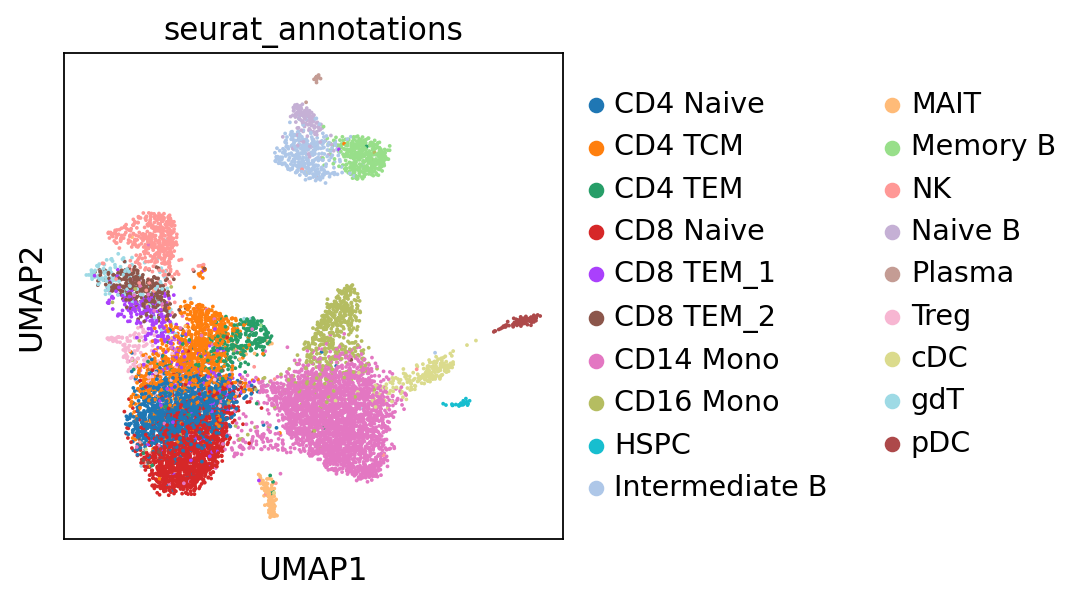

In [4]:
#UMAP with Combat batch correction and all genes
sc.set_figure_params(scanpy=True, dpi=80)
sc.pl.umap(anndat_mod1, color=["seurat_annotations"],
           show=True)

In [5]:
anndat_mod1 = anndat_mod1[anndat_mod1.obs.sort_values(by='seurat_annotations').index]
anndat_mod2 = anndat_mod2[anndat_mod1.obs_names]

In [6]:
gene_vec = np.arange(0,20,20/anndat_mod1.n_obs).reshape(-1,1)
peak_vec = np.arange(0,10,10/anndat_mod1.n_obs).reshape(-1,1)

In [7]:
#shuffle
def perc_shuffle(gene_vec, peak_vec, perc):
    np.random.seed(1)
    random.seed(1)
    sf_size = int(perc*len(gene_vec))
    sf_bool = np.zeros(len(gene_vec))
    sf_bool[np.random.choice(np.arange(len(gene_vec)), sf_size, replace=False)] = 1
    
    all_ind = np.arange(len(gene_vec))
    sf_ind = np.random.choice(all_ind[sf_bool==1], sf_size, replace=False)
    all_ind[sf_bool==1] = sf_ind
    
    gene_sf = gene_vec[all_ind]
    peak_sf = peak_vec[all_ind]
    
    return gene_sf, peak_sf


X_gene = np.zeros((anndat_mod1.n_obs,0))
X_peak = np.zeros((anndat_mod1.n_obs,0))

X_gene = np.concatenate([X_gene, gene_vec], axis=1)
X_peak = np.concatenate([X_peak, peak_vec], axis=1)

shuffle_time = 200
for i in range(shuffle_time):
    for j in range(20):
        #sf_ind = np.random.choice(np.arange(anndat_mod1.n_obs), anndat_mod1.n_obs, replace=False)
        #X_gene = np.concatenate([X_gene, gene_vec[sf_ind]], axis=1)
        #X_peak = np.concatenate([X_peak, peak_vec[sf_ind]], axis=1)
        gene_sf, peak_sf = perc_shuffle(gene_vec, peak_vec, perc=i/shuffle_time)
        X_gene = np.concatenate([X_gene, gene_sf], axis=1)
        X_peak = np.concatenate([X_peak, peak_sf], axis=1)

    


In [8]:
# Create multiome object
weights = anndat_mod1.obsp['connectivities']
#distance = anndat_mod1.obsp['distances']
anndat_multiome = ad.AnnData(
    X = np.concatenate((X_gene, X_peak), axis=1),
    obs = anndat_mod1.obs,
    obsm = anndat_mod1.obsm,
    obsp = {'connectivities': weights}, #, 'distances':distance},
    #var = pd.concat([anndat_mod1.raw.var.loc[gene_mask,:],anndat_mod2.var.loc[peak_mask,:]]),
)

gene_names = np.core.defchararray.add(['G.'], np.arange(shuffle_time*20+1).astype(str))
peak_names = np.core.defchararray.add(['P.'], np.arange(shuffle_time*20+1).astype(str))
anndat_multiome.var_names = np.concatenate([gene_names, peak_names])
anndat_multiome.obs_names = anndat_mod1.obs_names

peaks_nearby = pd.DataFrame({'genes': gene_names,
                             'peaks': peak_names})
anndat_multiome.uns['peaks_nearby'] = peaks_nearby

/tmp/ipykernel_2587642/2083470066.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndat_multiome = ad.AnnData(


In [9]:
anndat_multiome.write_h5ad('PBMC.simulation.h5ad')

### SNARE-seq data <a name="snare"></a>

#### The whole dataset paeudo-bulk object <a name="snarepb"></a>

In [2]:
anndat_mod1 = ad.read_h5ad('snare_seq/SNARE_mousebrain_RNA.h5ad')
anndat_mod2 = ad.read_h5ad('snare_seq/SNARE_mousebrain_ATAC.h5ad')

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

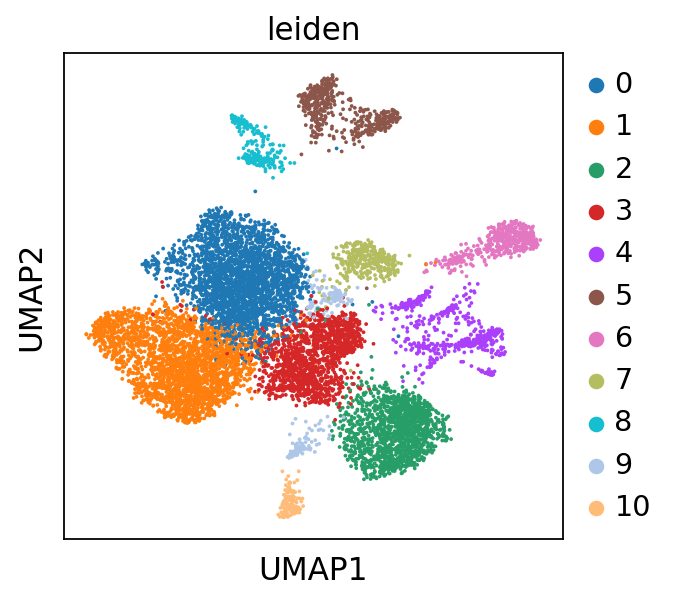

In [3]:
sc.pl.umap(anndat_mod1,color='leiden')


In [4]:
import multiome.data_preparation as dp
nn_map = dp.nn_map_scanpy(anndat_mod1, K=25) #K should be exactly the same as n_neighbors in sc.pp.neighbors

In [5]:
anndat_mod1 = dp.add_group_sparsity(anndat_mod1)
anndat_mod2 = dp.add_group_sparsity(anndat_mod2)

In [6]:
import time
start = time.time()
bulk_mod1, bulk_mod2 = dp.PsedoBulk(anndat_mod1, anndat_mod2,
                                    group_name='leiden',
                                    nn_map=nn_map, N=5000, K=25)
print('Finished in %.2fs'%(time.time()-start))

Cluster annotation provided, will generate the pseudo-bulk within each cluster defined...


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


5000 pseudo-bulk generated


/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:304: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return ad.AnnData(
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:308: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ), ad.AnnData(


Finished in 33.93s


In [7]:
bulk_mod1 = dp.RNA_preprocessing_in_one(bulk_mod1, HVGs=None,
                                        sparse_cutoff=0.1)
bulk_mod2 = dp.ATAC_preprocessing_in_one(bulk_mod2,
                                         sparse_cutoff=0.05)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 10.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 5.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [8]:
# peaks nearby annotation
import multiome.feature_pairing as feature_pairing
start = time.time()
#genes = anndat_rna.var_names[anndat_rna.var.highly_variable]
genes = bulk_mod1.raw.var_names #np.intersect1d(genes, bulk_mod1.raw.var_names.to_numpy())
peaks = bulk_mod2.var_names
peaks_nearby = feature_pairing.peaks_within_distance(genes, peaks,
                                                     upstream=100000,
                                                     downstream=100000,
                                                     id_type='Symbol',
                                                     split_symbol=[':','-'],
                                                     ref_gtf_fn='snare_seq/Mus_musculus.GRCm38.100.GeneLoc.Tab.txt')
print('Finished in %.2fs'%(time.time()-start))

Remove nearby peaks if it lies on the gene body or promoter regions of other genes.
Finished in 108.21s


In [9]:
peaks_nearby.to_csv('snare_seq/SNARE_mousebrain.peaks_nearby.all.csv')

In [10]:
peaks_nearby = pd.read_csv('snare_seq/SNARE_mousebrain.peaks_nearby.all.csv',index_col=0)
anndat_multiome = dp.multiome_data(bulk_mod1, bulk_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [11]:
anndat_multiome.write_h5ad('snare_seq/SNARE_mousebrain.all.pseudo.h5ad')

#### Cluster 2 pseudo-bulk object <a name="snare2"></a>

In [2]:
import multiome.data_preparation as dp

anndat_mod1 = ad.read_h5ad('snare_seq/SNARE_mousebrain_RNA.h5ad')
anndat_mod2 = ad.read_h5ad('snare_seq/SNARE_mousebrain_ATAC.h5ad')

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

import multiome.data_preparation as dp
nn_map = dp.nn_map_scanpy(anndat_mod1, K=25)

anndat_mod1, anndat_mod2, nn_map = dp.subset(anndat_mod1, anndat_mod2,
                                             nn_map, by='leiden',
                                             groups = ['2'])

In [3]:
anndat_mod1 = dp.add_group_sparsity(anndat_mod1)
anndat_mod2 = dp.add_group_sparsity(anndat_mod2)

/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:180: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndat.var['Frac.all'] = non_zero_pd['sparsity'].to_numpy()
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:180: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndat.var['Frac.all'] = non_zero_pd['sparsity'].to_numpy()


In [4]:
import time
start = time.time()
bulk_mod1, bulk_mod2 = dp.PsedoBulk(anndat_mod1, anndat_mod2,
                                    #group_name='leiden',
                                    nn_map=nn_map, N=2000, K=25)
print('Finished in %.2fs'%(time.time()-start))

No cluster annotation provided, will generate the pseudo-bulk by KNN...
1412 pseudo-bulk generated


/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:304: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return ad.AnnData(
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:308: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ), ad.AnnData(


Finished in 7.31s


In [5]:
bulk_mod1 = dp.RNA_preprocessing_in_one(bulk_mod1, HVGs=None,
                                        sparse_cutoff=0.1)
bulk_mod2 = dp.ATAC_preprocessing_in_one(bulk_mod2,
                                         sparse_cutoff=0.05)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 10.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 5.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [6]:
genes = bulk_mod1.raw.var_names #np.intersect1d(genes, bulk_mod1.raw.var_names.to_numpy())
peaks = bulk_mod2.var_names
peaks_nearby = pd.read_csv('snare_seq/SNARE_mousebrain.peaks_nearby.all.csv', index_col=0)
peaks_nearby = peaks_nearby.loc[peaks_nearby['genes'].isin(genes),:]
peaks_nearby = peaks_nearby.loc[peaks_nearby['peaks'].isin(peaks),:]

peaks_nearby.to_csv('snare_seq/SNARE_mousebrain.peaks_nearby.2.csv', index=False)


In [7]:
peaks_nearby = pd.read_csv('snare_seq/SNARE_mousebrain.peaks_nearby.2.csv')
anndat_multiome = dp.multiome_data(bulk_mod1, bulk_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [8]:
anndat_multiome.write_h5ad('snare_seq/SNARE_mousebrain.2.pseudo.h5ad')

#### The whole dataset single-cell object <a name="snaresc"></a>

In [2]:
anndat_mod1 = ad.read_h5ad('snare_seq/SNARE_mousebrain_RNA.h5ad')
anndat_mod2 = ad.read_h5ad('snare_seq/SNARE_mousebrain_ATAC.h5ad')

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

In [3]:
import multiome.data_preparation as dp
anndat_mod1 = dp.add_group_sparsity(anndat_mod1)
anndat_mod2 = dp.add_group_sparsity(anndat_mod2)

In [4]:
bulk_mod1 = dp.RNA_preprocessing_in_one(anndat_mod1, HVGs=None,
                                        sparse_cutoff=0.)
bulk_mod2 = dp.ATAC_preprocessing_in_one(anndat_mod2,
                                         sparse_cutoff=0.)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 0.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 0.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [6]:
peaks_nearby = pd.read_csv('snare_seq/SNARE_mousebrain.peaks_nearby.all.csv', index_col=0)
anndat_multiome = dp.multiome_data(anndat_mod1, anndat_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [7]:
anndat_multiome.write_h5ad('snare_seq/SNARE_mousebrain.all.sc.h5ad')

### SHARE-seq data  <a name="share"></a>
#### The whole dataset paeudo-bulk object  <a name="sharepb"></a>

In [2]:
anndat_mod1 = ad.read_h5ad('share_seq/SHARE_mouseskin_RNA.h5ad')
anndat_mod2 = ad.read_h5ad('share_seq/SHARE_mouseskin_ATAC.h5ad')

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

In [4]:
np.all(anndat_mod1.obs_names == anndat_mod2.obs_names)

True

In [5]:
import multiome.data_preparation as dp
nn_map = dp.nn_map_scanpy(anndat_mod1, K=25) #K should be exactly the same as n_neighbors in sc.pp.neighbors

In [6]:
anndat_mod1 = dp.add_group_sparsity(anndat_mod1)
anndat_mod2 = dp.add_group_sparsity(anndat_mod2)

In [7]:
import time
start = time.time()
bulk_mod1, bulk_mod2 = dp.PsedoBulk(anndat_mod1, anndat_mod2,
                                    group_name='leiden',
                                    nn_map=nn_map, N=5000, K=25)
print('Finished in %.2fs'%(time.time()-start))

Cluster annotation provided, will generate the pseudo-bulk within each cluster defined...


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


5000 pseudo-bulk generated


/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:304: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return ad.AnnData(
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:308: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ), ad.AnnData(


Finished in 60.59s


In [8]:
bulk_mod1 = dp.RNA_preprocessing_in_one(bulk_mod1, HVGs=None,
                                        sparse_cutoff=0.1)
bulk_mod2 = dp.ATAC_preprocessing_in_one(bulk_mod2,
                                         sparse_cutoff=0.05)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 10.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 5.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [9]:
# peaks nearby annotation
import multiome.feature_pairing as feature_pairing
start = time.time()
genes = bulk_mod1.raw.var_names #np.intersect1d(genes, bulk_mod1.raw.var_names.to_numpy())
peaks = bulk_mod2.var_names
peaks_nearby = feature_pairing.peaks_within_distance(genes, peaks,
                                                     upstream=100000,
                                                     downstream=100000,
                                                     id_type='Symbol',
                                                     split_symbol=[':','-'],
                                                     ref_gtf_fn='snare_seq/Mus_musculus.GRCm38.100.GeneLoc.Tab.txt')
print('Finished in %.2fs'%(time.time()-start))

Remove nearby peaks if it lies on the gene body or promoter regions of other genes.
Finished in 159.63s


In [10]:
peaks_nearby.to_csv('share_seq/SHARE_mouseskin.peaks_nearby.all.csv')

In [11]:
peaks_nearby = pd.read_csv('share_seq/SHARE_mouseskin.peaks_nearby.all.csv',index_col=0)
anndat_multiome = dp.multiome_data(bulk_mod1, bulk_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [12]:
anndat_multiome.write_h5ad('share_seq/SHARE_mouseskin.all.pseudo.h5ad')

#### Cluster 7 pseudo-bulk object   <a name="share7"></a>

In [2]:
import multiome.data_preparation as dp

anndat_mod1 = ad.read_h5ad('share_seq/SHARE_mouseskin_RNA.h5ad')
anndat_mod2 = ad.read_h5ad('share_seq/SHARE_mouseskin_ATAC.h5ad')

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

import multiome.data_preparation as dp
nn_map = dp.nn_map_scanpy(anndat_mod1, K=25)

anndat_mod1, anndat_mod2, nn_map = dp.subset(anndat_mod1, anndat_mod2,
                                             nn_map, by='leiden',
                                             groups = ['7'])

In [3]:
anndat_mod1 = dp.add_group_sparsity(anndat_mod1)
anndat_mod2 = dp.add_group_sparsity(anndat_mod2)

/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:180: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndat.var['Frac.all'] = non_zero_pd['sparsity'].to_numpy()
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:180: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndat.var['Frac.all'] = non_zero_pd['sparsity'].to_numpy()


In [4]:
import time
start = time.time()
bulk_mod1, bulk_mod2 = dp.PsedoBulk(anndat_mod1, anndat_mod2,
                                    #group_name='leiden',
                                    nn_map=nn_map, N=2000, K=25)
print('Finished in %.2fs'%(time.time()-start))

No cluster annotation provided, will generate the pseudo-bulk by KNN...
1417 pseudo-bulk generated


/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:304: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return ad.AnnData(
/mnt/atlas_local/chaozhong/data/thesis/fig2/../multiome/data_preparation.py:308: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ), ad.AnnData(


Finished in 11.62s


In [5]:
bulk_mod1 = dp.RNA_preprocessing_in_one(bulk_mod1, HVGs=None,
                                        sparse_cutoff=0.1)
bulk_mod2 = dp.ATAC_preprocessing_in_one(bulk_mod2,
                                         sparse_cutoff=0.05)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 10.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 5.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [6]:
genes = bulk_mod1.raw.var_names #np.intersect1d(genes, bulk_mod1.raw.var_names.to_numpy())
peaks = bulk_mod2.var_names
peaks_nearby = pd.read_csv('share_seq/SHARE_mouseskin.peaks_nearby.all.csv', index_col=0)
peaks_nearby = peaks_nearby.loc[peaks_nearby['genes'].isin(genes),:]
peaks_nearby = peaks_nearby.loc[peaks_nearby['peaks'].isin(peaks),:]

peaks_nearby.to_csv('share_seq/SHARE_mouseskin.peaks_nearby.7.csv', index=False)


In [7]:
peaks_nearby = pd.read_csv('share_seq/SHARE_mouseskin.peaks_nearby.7.csv')
anndat_multiome = dp.multiome_data(bulk_mod1, bulk_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [8]:
anndat_multiome.write_h5ad('share_seq/SHARE_mouseskin.7.pseudo.h5ad')

#### The whole dataset single-cell object   <a name="sharesc"></a>

In [2]:
anndat_mod1 = ad.read_h5ad('share_seq/SHARE_mouseskin_RNA.h5ad')
anndat_mod2 = ad.read_h5ad('share_seq/SHARE_mouseskin_ATAC.h5ad')

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

In [3]:
import multiome.data_preparation as dp
anndat_mod1 = dp.add_group_sparsity(anndat_mod1)
anndat_mod2 = dp.add_group_sparsity(anndat_mod2)

In [4]:
bulk_mod1 = dp.RNA_preprocessing_in_one(anndat_mod1, HVGs=None,
                                        sparse_cutoff=0.)
bulk_mod2 = dp.ATAC_preprocessing_in_one(anndat_mod2,
                                         sparse_cutoff=0.)

---- scRNA-seq pre-processing -----
Filter genes expressed in less than 0.0% cells...
Do library size correction and log-transformation...
Highly-variable genes not provided, will use scanpy.pp.highly_variable_genes defined HVGs.
Perform dimension reduction with HVGs


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing done!
---- scATAC-seq pre-processing -----
Filter peaks expressed in less than 0.0% cells
Do library size correction, log-transformation, and scaling...
Preprocessing done!


In [7]:
peaks_nearby = pd.read_csv('share_seq/SHARE_mouseskin.peaks_nearby.all.csv', index_col=0)
anndat_multiome = dp.multiome_data(anndat_mod1, anndat_mod2, peaks_nearby)

AnnData object genertated with log-transformed data as X.


In [8]:
anndat_multiome.write_h5ad('share_seq/SHARE_mouseskin.all.sc.h5ad') # extremely big!